# Analysis

The goal of this analysis is to assess improvement in classical HLA quantifiaction from noPers to Pers by examining changes in gene expression and read alignment from noPers and Pers.

By Amber Shen and Joyce Kang

Last updated June 2023

# Outline
1. Percent Change across cohorts
2. Percent Change vs. distance from reference allele (3' and 5')
3. Compare dissimilarity from the reference for 5' and 3'
4. Dissect the trend in HLA-B and HLA-C for 3' data

# % Change across cohorts

In [1]:
suppressPackageStartupMessages({    
    library(Matrix)
    library(tidyverse)
    library(ggplot2)
    library(stringr)
    library(ggrepel)
    library(reshape2)
    library(gridExtra)
    library(ggallin)
    library(patchwork)
})
source('../utils.R')

Get HLA genes and other MHC genes

In [2]:
HLA_genes = c('HLA-A', 'HLA-B', 'HLA-C', 'HLA-DRB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1')
IMGT_genes = c('IMGT_A', 'IMGT_B', 'IMGT_C', 'IMGT_DRB1', 'IMGT_DQA1', 'IMGT_DQB1', 'IMGT_DPA1', 'IMGT_DPB1')
ref_alleles = c('HLA_A*03:01', 'HLA_B*07:02', 'HLA_C*07:02', 'HLA_DPA1*01:03', 
                'HLA_DPB1*04:01', 'HLA_DQA1*01:02', 'HLA_DQB1*06:02', 'HLA_DRB1*15:01')

## AMP2RA

In [3]:
# File paths
pers_file = '../../data/genesXcells_GeneFull_Ex50pAS/exp_AMP2RA_pers_EM_GeneFull_Exon50pAS.rds'
noPers_file = '../../data/genesXcells_GeneFull_Ex50pAS/exp_AMP2RA_noPers_noMM_GeneFull_Exon50pAS.rds'
cell_meta_file = '../../data/meta/cell_meta_AMP2RA_completeHLA.csv'
cell_meta = read.csv(cell_meta_file)
dataset = 'AMP2RA'

m_pers = readRDS(pers_file)
rownames(m_pers) = str_replace(rownames(m_pers), 'IMGT_', 'HLA-') # Rename 'IMGT' to 'HLA'
# Subset to HLA genes
m_pers_HLA = m_pers[HLA_genes, ] 
rm(m_pers)

m_noPers = readRDS(noPers_file)
m_noPers_HLA = m_noPers[HLA_genes, ]
rm(m_noPers)

In [4]:
# Reorder cells to match the metadata ordering
m_pers_HLA = m_pers_HLA[, cell_meta$Cell]
m_noPers_HLA = m_noPers_HLA[, cell_meta$Cell]

dim(m_pers_HLA)
dim(m_noPers_HLA)
all(colnames(m_pers_HLA) == cell_meta$Cell)
all(colnames(m_noPers_HLA) == cell_meta$Cell)
all(rownames(m_pers_HLA) == rownames(m_noPers_HLA))

[1]      8 278237

[1]      8 278237

[1] TRUE

[1] TRUE

[1] TRUE

Plot HLA genes - boxplot by sample

Warning message:
“Ignoring unknown parameters: linewidth”


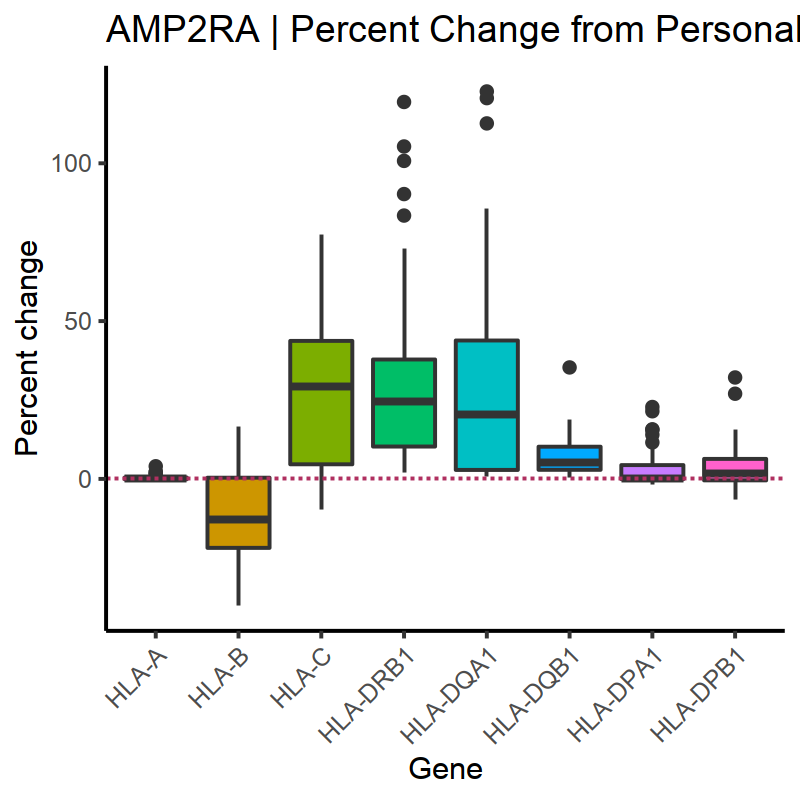

In [5]:
# Sum by sample
pers_sample = rowsum(as.matrix(t(m_pers_HLA)), cell_meta$Sample, reorder = TRUE)
noPers_sample = rowsum(as.matrix(t(m_noPers_HLA)), cell_meta$Sample, reorder = TRUE)

pctinc = 100 * (pers_sample - noPers_sample) / noPers_sample

pctinc_long <- melt(data = pctinc, 
                id.vars = colnames(pctinc),
                variable.name = "gene",
                value.name = "pct_change")
colnames(pctinc_long) = c('sample', 'gene', 'pct_change')

fig.size(4, 4)
ggplot(pctinc_long) +
    geom_boxplot(aes(x = gene, y =  pct_change, fill = gene)) + theme_bw() +
    xlab('Gene') + ggtitle('AMP2RA | Percent Change from Personalized Pipeline') + ylab('Percent change') + 
    theme_classic() + theme(legend.position = 'none') +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + 
    geom_hline(yintercept=0, color = 'maroon', linewidth = 1, linetype = 'dashed')

In [7]:
pctinc_long_AMP2RA = pctinc_long
pctinc_long_AMP2RA$dataset = 'AMP2RA'
saveRDS(pctinc_long_AMP2RA, 'percent_change_results/pctinc_long_AMP2RA.rds')

In [43]:
pctinc_long_AMP2RA = readRDS('percent_change_results/pctinc_long_AMP2RA.rds')

In [44]:
alleles = read.csv('../../data/hla_alleles/HLA_alleles_table_AMP2RA.csv') %>%
    dplyr::select(Geno_ID, Sample, Allele, Gene, GT)
head(alleles)
alleles = alleles %>% mutate(matchesRef = ifelse(Allele %in% ref_alleles, TRUE, FALSE))
alleles$Gene = str_replace(alleles$Gene, '_', '-')
head(alleles)

,Geno_ID,Sample,Allele,Gene,GT
,<chr>,<chr>,<chr>,<chr>,<chr>
1,301-0267,BRI-399,HLA_A*01:01,HLA_A,0|1
2,301-0267,BRI-399,HLA_A*02:01,HLA_A,1|0
3,301-0267,BRI-399,HLA_C*05:01,HLA_C,1|0
4,301-0267,BRI-399,HLA_C*07:01,HLA_C,0|1
5,301-0267,BRI-399,HLA_B*08:01,HLA_B,0|1
6,301-0267,BRI-399,HLA_B*44:02,HLA_B,1|0


,Geno_ID,Sample,Allele,Gene,GT,matchesRef
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
1,301-0267,BRI-399,HLA_A*01:01,HLA-A,0|1,FALSE
2,301-0267,BRI-399,HLA_A*02:01,HLA-A,1|0,FALSE
3,301-0267,BRI-399,HLA_C*05:01,HLA-C,1|0,FALSE
4,301-0267,BRI-399,HLA_C*07:01,HLA-C,0|1,FALSE
5,301-0267,BRI-399,HLA_B*08:01,HLA-B,0|1,FALSE
6,301-0267,BRI-399,HLA_B*44:02,HLA-B,1|0,FALSE


In [45]:
sample_meta = read.csv('../../data/meta/sample_meta_AMP2RA_completeHLA.csv')

pctinc_long_AMP2RA$numRefAlleles = 0
for (i in 1:nrow(pctinc_long_AMP2RA)) {
    gene = pctinc_long_AMP2RA[i, 'gene']
    sample = pctinc_long_AMP2RA[i, 'sample']
    
    alleles_sample = alleles[which(alleles$Sample == sample & alleles$Gene == gene),]
    if (all(alleles_sample$matchesRef == TRUE)) {
        pctinc_long_AMP2RA[i, 'numRefAlleles'] = 2
    } else if (all(alleles_sample$matchesRef == FALSE)) {
        pctinc_long_AMP2RA[i, 'numRefAlleles'] = 0
    } else {pctinc_long_AMP2RA[i, 'numRefAlleles'] = 1}
}

table(pctinc_long_AMP2RA$gene, pctinc_long_AMP2RA$numRefAlleles)

          
            0  1  2
  HLA-A    53 16  0
  HLA-B    52 17  0
  HLA-C    51 18  0
  HLA-DRB1 56 13  0
  HLA-DQA1 50 17  2
  HLA-DQB1 55 14  0
  HLA-DPA1 10 19 40
  HLA-DPB1 31 22 16

In [55]:
saveRDS(pctinc_long_AMP2RA, 'percent_change_results/pctinc_long_AMP2RA.rds')

## Smillie2019

In [8]:
# File paths
pers_file = '../../data/genesXcells_GeneFull_Ex50pAS/exp_Smillie_pers_EM_GeneFull_Exon50pAS.rds'
noPers_file = '../../data/genesXcells_GeneFull_Ex50pAS/exp_Smillie_noPers_noMM_GeneFull_Exon50pAS.rds'
cell_meta_file = '../../data/meta/cell_meta_Smillie_completeHLA.csv'
cell_meta = read.csv(cell_meta_file)
dataset = 'Smillie2019'

m_pers = readRDS(pers_file)
rownames(m_pers) = str_replace(rownames(m_pers), 'IMGT_', 'HLA-') # Rename 'IMGT' to 'HLA'
# Subset to HLA genes
m_pers_HLA = m_pers[HLA_genes, ] 
rm(m_pers)

m_noPers = readRDS(noPers_file)
m_noPers_HLA = m_noPers[HLA_genes, ]
rm(m_noPers)

In [9]:
# Reorder cells to match the metadata ordering
m_pers_HLA = m_pers_HLA[, cell_meta$Cell]
m_noPers_HLA = m_noPers_HLA[, cell_meta$Cell]

dim(m_pers_HLA)
dim(m_noPers_HLA)
all(colnames(m_pers_HLA) == cell_meta$Cell)
all(colnames(m_noPers_HLA) == cell_meta$Cell)
all(rownames(m_pers_HLA) == rownames(m_noPers_HLA))

[1]      8 265629

[1]      8 265629

[1] TRUE

[1] TRUE

[1] TRUE

Plot HLA genes - boxplot by sample

Warning message:
“Ignoring unknown parameters: linewidth”


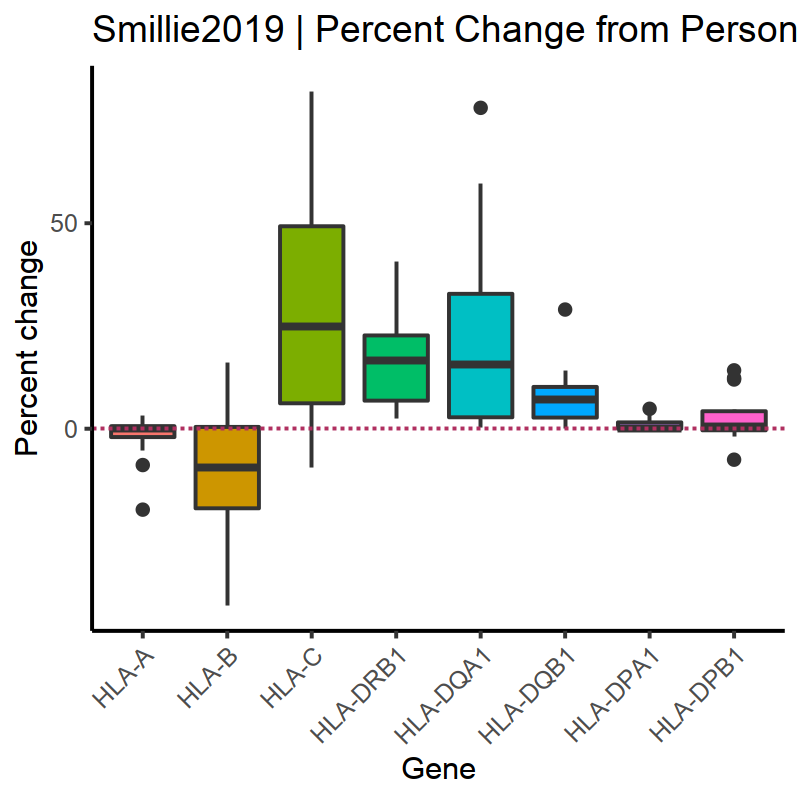

In [10]:
# Sum by sample
pers_sample = rowsum(as.matrix(t(m_pers_HLA)), cell_meta$Sample, reorder = TRUE)
noPers_sample = rowsum(as.matrix(t(m_noPers_HLA)), cell_meta$Sample, reorder = TRUE)

pctinc = 100 * (pers_sample - noPers_sample) / noPers_sample

pctinc_long <- melt(data = pctinc, 
                id.vars = colnames(pctinc),
                variable.name = "gene",
                value.name = "pct_change")
colnames(pctinc_long) = c('sample', 'gene', 'pct_change')

fig.size(4, 4)
ggplot(pctinc_long) +
    geom_boxplot(aes(x = gene, y =  pct_change, fill = gene)) + theme_bw() +
    xlab('Gene') + ggtitle('Smillie2019 | Percent Change from Personalized Pipeline') + 
    ylab('Percent change') + 
    theme_classic() + theme(legend.position = 'none') +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + 
    geom_hline(yintercept=0, color = 'maroon', linewidth = 1, linetype = 'dashed')

In [13]:
pctinc_long_Smillie = pctinc_long
pctinc_long_Smillie$dataset = 'Smillie2019'
saveRDS(pctinc_long_Smillie, 'percent_change_results/pctinc_long_Smillie2019.rds')

In [46]:
pctinc_long_Smillie = readRDS('percent_change_results/pctinc_long_Smillie2019.rds')

In [47]:
alleles = read.csv('../../data/hla_alleles/HLA_alleles_table_Smillie_ccdg.csv') %>%
    rbind(read.csv('../../data/hla_alleles/HLA_alleles_table_Smillie_Helmsley.csv')) %>% 
    dplyr::select(Geno_ID, Sample, Allele, Gene, GT)
head(alleles)
alleles = alleles %>% mutate(matchesRef = ifelse(Allele %in% ref_alleles, TRUE, FALSE))
alleles$Gene = str_replace(alleles$Gene, '_', '-')
head(alleles)

,Geno_ID,Sample,Allele,Gene,GT
,<chr>,<chr>,<chr>,<chr>,<chr>
1,202279080102_R08C01,N24,HLA_A*03:01,HLA_A,1|0
2,202279080102_R08C01,N24,HLA_A*11:01,HLA_A,0|1
3,202279080102_R08C01,N24,HLA_C*04:01,HLA_C,1|1
4,202279080102_R08C01,N24,HLA_B*35:01,HLA_B,0|1
5,202279080102_R08C01,N24,HLA_B*50:01,HLA_B,1|0
6,202279080102_R08C01,N24,HLA_DRB1*10:01,HLA_DRB1,0|1


,Geno_ID,Sample,Allele,Gene,GT,matchesRef
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
1,202279080102_R08C01,N24,HLA_A*03:01,HLA-A,1|0,TRUE
2,202279080102_R08C01,N24,HLA_A*11:01,HLA-A,0|1,FALSE
3,202279080102_R08C01,N24,HLA_C*04:01,HLA-C,1|1,FALSE
4,202279080102_R08C01,N24,HLA_B*35:01,HLA-B,0|1,FALSE
5,202279080102_R08C01,N24,HLA_B*50:01,HLA-B,1|0,FALSE
6,202279080102_R08C01,N24,HLA_DRB1*10:01,HLA-DRB1,0|1,FALSE


In [48]:
sample_meta = read.csv('../../data/meta/sample_meta_Smillie_completeHLA.csv')

pctinc_long_Smillie$numRefAlleles = 0
for (i in 1:nrow(pctinc_long_Smillie)) {
    gene = pctinc_long_Smillie[i, 'gene']
    sample = pctinc_long_Smillie[i, 'sample']
    
    alleles_sample = alleles[which(alleles$Sample == sample & alleles$Gene == gene),]
    if (all(alleles_sample$matchesRef == TRUE)) {
        pctinc_long_Smillie[i, 'numRefAlleles'] = 2
    } else if (all(alleles_sample$matchesRef == FALSE)) {
        pctinc_long_Smillie[i, 'numRefAlleles'] = 0
    } else {pctinc_long_Smillie[i, 'numRefAlleles'] = 1}
}

table(pctinc_long_Smillie$gene, pctinc_long_Smillie$numRefAlleles)

          
            0  1  2
  HLA-A    16  5  1
  HLA-B    16  6  0
  HLA-C    16  6  0
  HLA-DRB1 17  4  1
  HLA-DQA1 15  6  1
  HLA-DQB1 16  5  1
  HLA-DPA1  0  9 13
  HLA-DPB1  5 12  5

In [57]:
saveRDS(pctinc_long_Smillie, 'percent_change_results/pctinc_long_Smillie2019.rds')

## Randolph2021

In [16]:
# File paths
pers_file = '../../data/genesXcells_GeneFull_Ex50pAS/exp_Randolph2021_pers_EM_GeneFull_Exon50pAS.rds'
noPers_file = '../../data/genesXcells_GeneFull_Ex50pAS/exp_Randolph2021_noPers_noMM_GeneFull_Exon50pAS.rds'
cell_meta_file = '../../data/meta/cell_meta_Randolph_completeHLA.csv'
cell_meta = read.csv(cell_meta_file)
dataset = 'Randolph2021'

m_pers = readRDS(pers_file)
rownames(m_pers) = str_replace(rownames(m_pers), 'IMGT_', 'HLA-') # Rename 'IMGT' to 'HLA'
# Subset to HLA genes
m_pers_HLA = m_pers[HLA_genes, ] 
rm(m_pers)

m_noPers = readRDS(noPers_file)
m_noPers_HLA = m_noPers[HLA_genes, ]
rm(m_noPers)

In [17]:
# Reorder cells to match the metadata ordering
m_pers_HLA = m_pers_HLA[, cell_meta$Cell]
m_noPers_HLA = m_noPers_HLA[, cell_meta$Cell]

dim(m_pers_HLA)
dim(m_noPers_HLA)
all(colnames(m_pers_HLA) == cell_meta$Cell)
all(colnames(m_noPers_HLA) == cell_meta$Cell)
all(rownames(m_pers_HLA) == rownames(m_noPers_HLA))

[1]      8 189488

[1]      8 189488

[1] TRUE

[1] TRUE

[1] TRUE

Plot HLA genes - boxplot by sample

Warning message:
“Ignoring unknown parameters: linewidth”


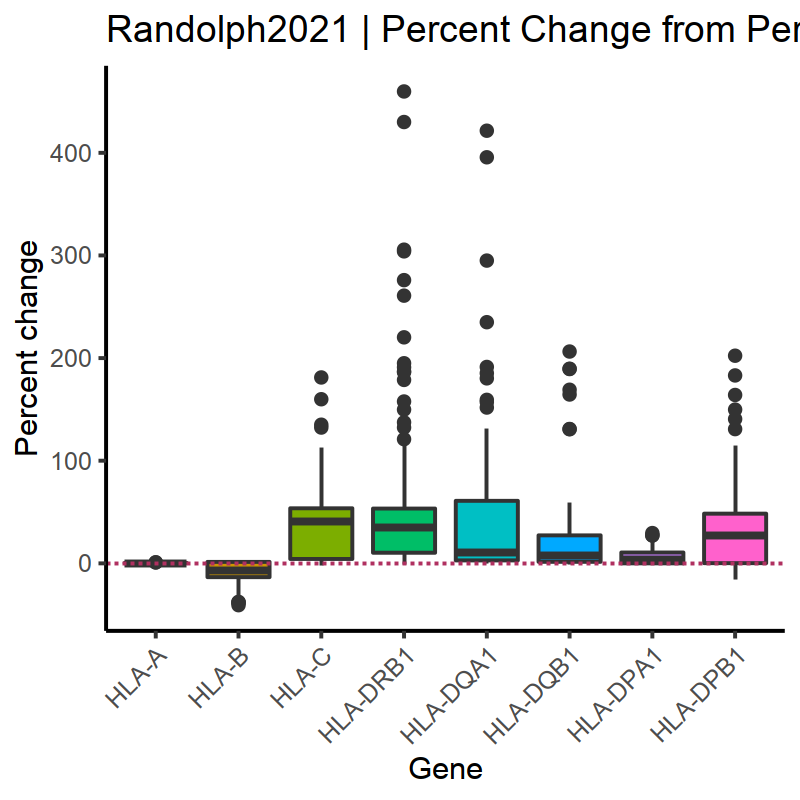

In [21]:
# Sum by sample
pers_sample = rowsum(as.matrix(t(m_pers_HLA)), cell_meta$Sample, reorder = TRUE)
noPers_sample = rowsum(as.matrix(t(m_noPers_HLA)), cell_meta$Sample, reorder = TRUE)

pctinc = 100 * (pers_sample - noPers_sample) / noPers_sample

pctinc_long <- melt(data = pctinc, 
                id.vars = colnames(pctinc),
                variable.name = "gene",
                value.name = "pct_change")
colnames(pctinc_long) = c('sample', 'gene', 'pct_change')

fig.size(4, 4)
ggplot(pctinc_long) +
    geom_boxplot(aes(x = gene, y =  pct_change, fill = gene)) + theme_bw() +
    xlab('Gene') + ggtitle('Randolph2021 | Percent Change from Personalized Pipeline') + ylab('Percent change') + 
    theme_classic() + theme(legend.position = 'none') +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + 
    geom_hline(yintercept=0, color = 'maroon', linewidth = 1, linetype = 'dashed')

In [23]:
pctinc_long_Randolph = pctinc_long
pctinc_long_Randolph$dataset = 'Randolph2021'
saveRDS(pctinc_long_Randolph, 'percent_change_results/pctinc_long_Randolph2021.rds')

In [50]:
pctinc_long_Randolph = readRDS('percent_change_results/pctinc_long_Randolph2021.rds')

In [49]:
alleles = read.csv('../../data/hla_alleles/HLA_alleles_table_Randolph.csv') %>%
    dplyr::select(Geno_ID, Sample, Allele, Gene, GT)
head(alleles)
alleles = alleles %>% mutate(matchesRef = ifelse(Allele %in% ref_alleles, TRUE, FALSE))
alleles$Gene = str_replace(alleles$Gene, '_', '-')
head(alleles)

,Geno_ID,Sample,Allele,Gene,GT
,<chr>,<chr>,<chr>,<chr>,<chr>
1,HMN83551,HMN83551_NI,HLA_A*02:01,HLA_A,1|1
2,HMN83551,HMN83551_flu,HLA_A*02:01,HLA_A,1|1
3,HMN83551,HMN83551_NI,HLA_C*05:01,HLA_C,1|0
4,HMN83551,HMN83551_flu,HLA_C*05:01,HLA_C,1|0
5,HMN83551,HMN83551_NI,HLA_C*07:02,HLA_C,0|1
6,HMN83551,HMN83551_flu,HLA_C*07:02,HLA_C,0|1


,Geno_ID,Sample,Allele,Gene,GT,matchesRef
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
1,HMN83551,HMN83551_NI,HLA_A*02:01,HLA-A,1|1,FALSE
2,HMN83551,HMN83551_flu,HLA_A*02:01,HLA-A,1|1,FALSE
3,HMN83551,HMN83551_NI,HLA_C*05:01,HLA-C,1|0,FALSE
4,HMN83551,HMN83551_flu,HLA_C*05:01,HLA-C,1|0,FALSE
5,HMN83551,HMN83551_NI,HLA_C*07:02,HLA-C,0|1,TRUE
6,HMN83551,HMN83551_flu,HLA_C*07:02,HLA-C,0|1,TRUE


In [51]:
sample_meta = read.csv('../../data/meta/sample_meta_Randolph_completeHLA.csv')

pctinc_long_Randolph$numRefAlleles = 0
for (i in 1:nrow(pctinc_long_Randolph)) {
    gene = pctinc_long_Randolph[i, 'gene']
    sample = pctinc_long_Randolph[i, 'sample']
    
    alleles_sample = alleles[which(alleles$Sample == sample & alleles$Gene == gene),]
    if (all(alleles_sample$matchesRef == TRUE)) {
        pctinc_long_Randolph[i, 'numRefAlleles'] = 2
    } else if (all(alleles_sample$matchesRef == FALSE)) {
        pctinc_long_Randolph[i, 'numRefAlleles'] = 0
    } else {pctinc_long_Randolph[i, 'numRefAlleles'] = 1}
}

table(pctinc_long_Randolph$gene, pctinc_long_Randolph$numRefAlleles)

          
             0   1   2
  HLA-A    120  26   0
  HLA-B    120  26   0
  HLA-C    122  24   0
  HLA-DRB1 132  14   0
  HLA-DQA1  70  62  14
  HLA-DQB1  90  50   6
  HLA-DPA1  42  46  58
  HLA-DPB1 100  36  10

In [58]:
saveRDS(pctinc_long_Randolph, 'percent_change_results/pctinc_long_Randolph2021.rds')

## OneK1K

In [24]:
# File paths
pers_file = '../../data/genesXcells_GeneFull_Ex50pAS/exp_OneK1K_pers_EM_GeneFull_Exon50pAS.rds'
noPers_file = '../../data/genesXcells_GeneFull_Ex50pAS/exp_OneK1K_noPers_noMM_GeneFull_Exon50pAS.rds'
cell_meta_file = '../../data/meta/cell_meta_OneK1K_completeHLA.csv'
cell_meta = read.csv(cell_meta_file)
dataset = 'OneK1K'

m_pers = readRDS(pers_file)
rownames(m_pers) = str_replace(rownames(m_pers), 'IMGT_', 'HLA-') # Rename 'IMGT' to 'HLA'
# Subset to HLA genes
m_pers_HLA = m_pers[HLA_genes, ] 
rm(m_pers)

m_noPers = readRDS(noPers_file)
m_noPers_HLA = m_noPers[HLA_genes, ]
rm(m_noPers)

In [25]:
# Reorder cells to match the metadata ordering
m_pers_HLA = m_pers_HLA[, cell_meta$Cell]
m_noPers_HLA = m_noPers_HLA[, cell_meta$Cell]

dim(m_pers_HLA)
dim(m_noPers_HLA)
all(colnames(m_pers_HLA) == cell_meta$Cell)
all(colnames(m_noPers_HLA) == cell_meta$Cell)
all(rownames(m_pers_HLA) == rownames(m_noPers_HLA))

[1]      8 772252

[1]      8 772252

[1] TRUE

[1] TRUE

[1] TRUE

Plot HLA genes - boxplot by sample

Warning message:
“Ignoring unknown parameters: linewidth”


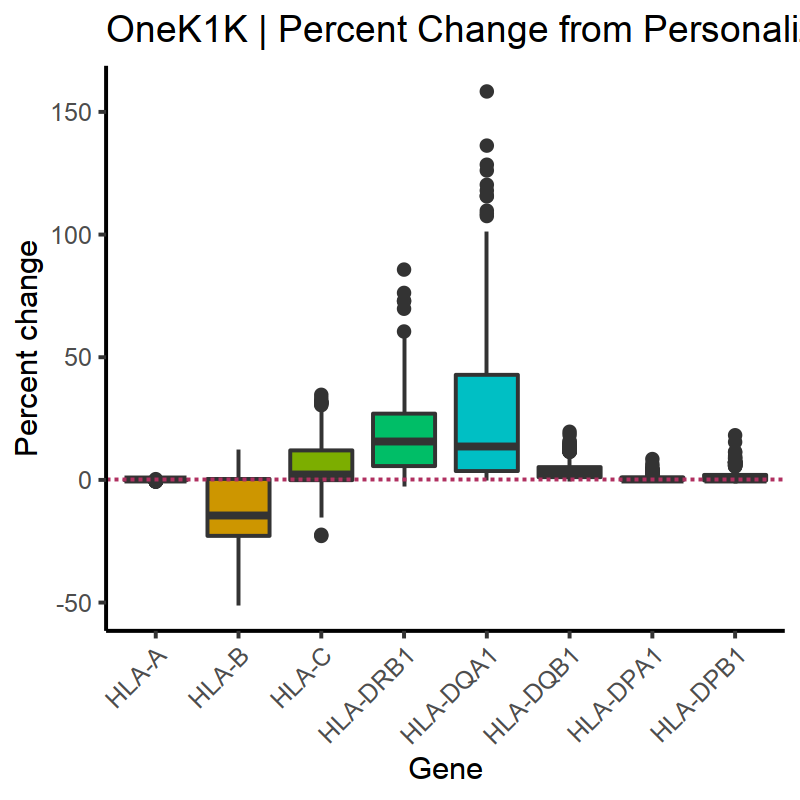

In [26]:
# Sum by sample
pers_sample = rowsum(as.matrix(t(m_pers_HLA)), cell_meta$Sample, reorder = TRUE)
noPers_sample = rowsum(as.matrix(t(m_noPers_HLA)), cell_meta$Sample, reorder = TRUE)

pctinc = 100 * (pers_sample - noPers_sample) / noPers_sample

pctinc_long <- melt(data = pctinc, 
                id.vars = colnames(pctinc),
                variable.name = "gene",
                value.name = "pct_change")
colnames(pctinc_long) = c('sample', 'gene', 'pct_change')

fig.size(4, 4)
ggplot(pctinc_long) +
    geom_boxplot(aes(x = gene, y =  pct_change, fill = gene)) + theme_bw() +
    xlab('Gene') + ggtitle('OneK1K | Percent Change from Personalized Pipeline') + ylab('Percent change') + 
    theme_classic() + theme(legend.position = 'none') +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + 
    geom_hline(yintercept=0, color = 'maroon', linewidth = 1, linetype = 'dashed')

In [28]:
pctinc_long_OneK1K = pctinc_long
pctinc_long_OneK1K$dataset = 'OneK1K'
saveRDS(pctinc_long_OneK1K, 'percent_change_results/pctinc_long_OneK1K.rds')

In [52]:
pctinc_long_OneK1K = readRDS('percent_change_results/pctinc_long_OneK1K.rds')

In [53]:
alleles = read.csv('../../data/hla_alleles/HLA_alleles_table_OneK1K.csv') %>%
    dplyr::select(Geno_ID, Sample, Allele, Gene, GT)
head(alleles)
alleles = alleles %>% mutate(matchesRef = ifelse(Allele %in% ref_alleles, TRUE, FALSE))
alleles$Gene = str_replace(alleles$Gene, '_', '-')
head(alleles)

,Geno_ID,Sample,Allele,Gene,GT
,<chr>,<chr>,<chr>,<chr>,<chr>
1,691_692,691_692,HLA_A*02:01,HLA_A,1|0
2,691_692,691_692,HLA_A*69:01,HLA_A,0|1
3,691_692,691_692,HLA_C*06:02,HLA_C,1|1
4,691_692,691_692,HLA_B*13:02,HLA_B,0|1
5,691_692,691_692,HLA_B*50:01,HLA_B,1|0
6,691_692,691_692,HLA_DRB1*07:01,HLA_DRB1,1|0


,Geno_ID,Sample,Allele,Gene,GT,matchesRef
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
1,691_692,691_692,HLA_A*02:01,HLA-A,1|0,FALSE
2,691_692,691_692,HLA_A*69:01,HLA-A,0|1,FALSE
3,691_692,691_692,HLA_C*06:02,HLA-C,1|1,FALSE
4,691_692,691_692,HLA_B*13:02,HLA-B,0|1,FALSE
5,691_692,691_692,HLA_B*50:01,HLA-B,1|0,FALSE
6,691_692,691_692,HLA_DRB1*07:01,HLA-DRB1,1|0,FALSE


In [54]:
sample_meta = read.csv('../../data/meta/sample_meta_OneK1K_completeHLA.csv')

pctinc_long_OneK1K$numRefAlleles = 0
for (i in 1:nrow(pctinc_long_OneK1K)) {
    gene = pctinc_long_OneK1K[i, 'gene']
    sample = pctinc_long_OneK1K[i, 'sample']
    
    alleles_sample = alleles[which(alleles$Sample == sample & alleles$Gene == gene),]
    if (all(alleles_sample$matchesRef == TRUE)) {
        pctinc_long_OneK1K[i, 'numRefAlleles'] = 2
    } else if (all(alleles_sample$matchesRef == FALSE)) {
        pctinc_long_OneK1K[i, 'numRefAlleles'] = 0
    } else {pctinc_long_OneK1K[i, 'numRefAlleles'] = 1}
}

table(pctinc_long_OneK1K$gene, pctinc_long_OneK1K$numRefAlleles)

          
             0   1   2
  HLA-A    672 215  22
  HLA-B    668 218  23
  HLA-C    658 227  24
  HLA-DRB1 672 218  19
  HLA-DQA1 597 282  30
  HLA-DQB1 666 226  17
  HLA-DPA1  39 255 615
  HLA-DPB1 274 468 167

In [59]:
saveRDS(pctinc_long_OneK1K, 'percent_change_results/pctinc_long_OneK1K.rds')

## Combined percent increase plot

In [60]:
pctinc_long_AMP2RA = readRDS('percent_change_results/pctinc_long_AMP2RA.rds')
pctinc_long_Smillie = readRDS('percent_change_results/pctinc_long_Smillie2019.rds')
pctinc_long_Randolph = readRDS('percent_change_results/pctinc_long_Randolph2021.rds')
pctinc_long_OneK1K = readRDS('percent_change_results/pctinc_long_OneK1K.rds')

# fix format for dataset name
pctinc_long_OneK1K$dataset = 'OneK1K'
pctinc_long_Randolph$dataset = 'Randolph2021'

pct_inc_combined = rbind(pctinc_long_AMP2RA, pctinc_long_OneK1K, pctinc_long_Randolph, pctinc_long_Smillie)
pct_inc_combined$dataset = factor(pct_inc_combined$dataset, levels = c('AMP2RA', 'Smillie2019', 'Randolph2021', 'OneK1K'))
pct_inc_combined$gene = factor(pct_inc_combined$gene, 
        levels = c('HLA-A', 'HLA-B', 'HLA-C', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1'))

# Rename datasets
pct_inc_combined$dataset = plyr::revalue(pct_inc_combined$dataset, old_new_dataset_names)
pct_inc_combined$dataset = factor(pct_inc_combined$dataset, 
                                  levels = c('Synovium', 'Intestine', 'PBMC-cultured', 'PBMC-blood'))
pct_inc_combined %>% head()

The following `from` values were not present in `x`: Smillie, Randolph_NI, Randolph



,sample,gene,pct_change,dataset,numRefAlleles
,<fct>,<fct>,<dbl>,<fct>,<dbl>
1,BRI-399,HLA-A,0.3291807,Synovium,0
2,BRI-401,HLA-A,3.9956233,Synovium,0
3,BRI-403,HLA-A,0.6744313,Synovium,0
4,BRI-405,HLA-A,0.5262038,Synovium,1
5,BRI-407,HLA-A,0.1908034,Synovium,0
6,BRI-409,HLA-A,-0.1111491,Synovium,1


png 
  2

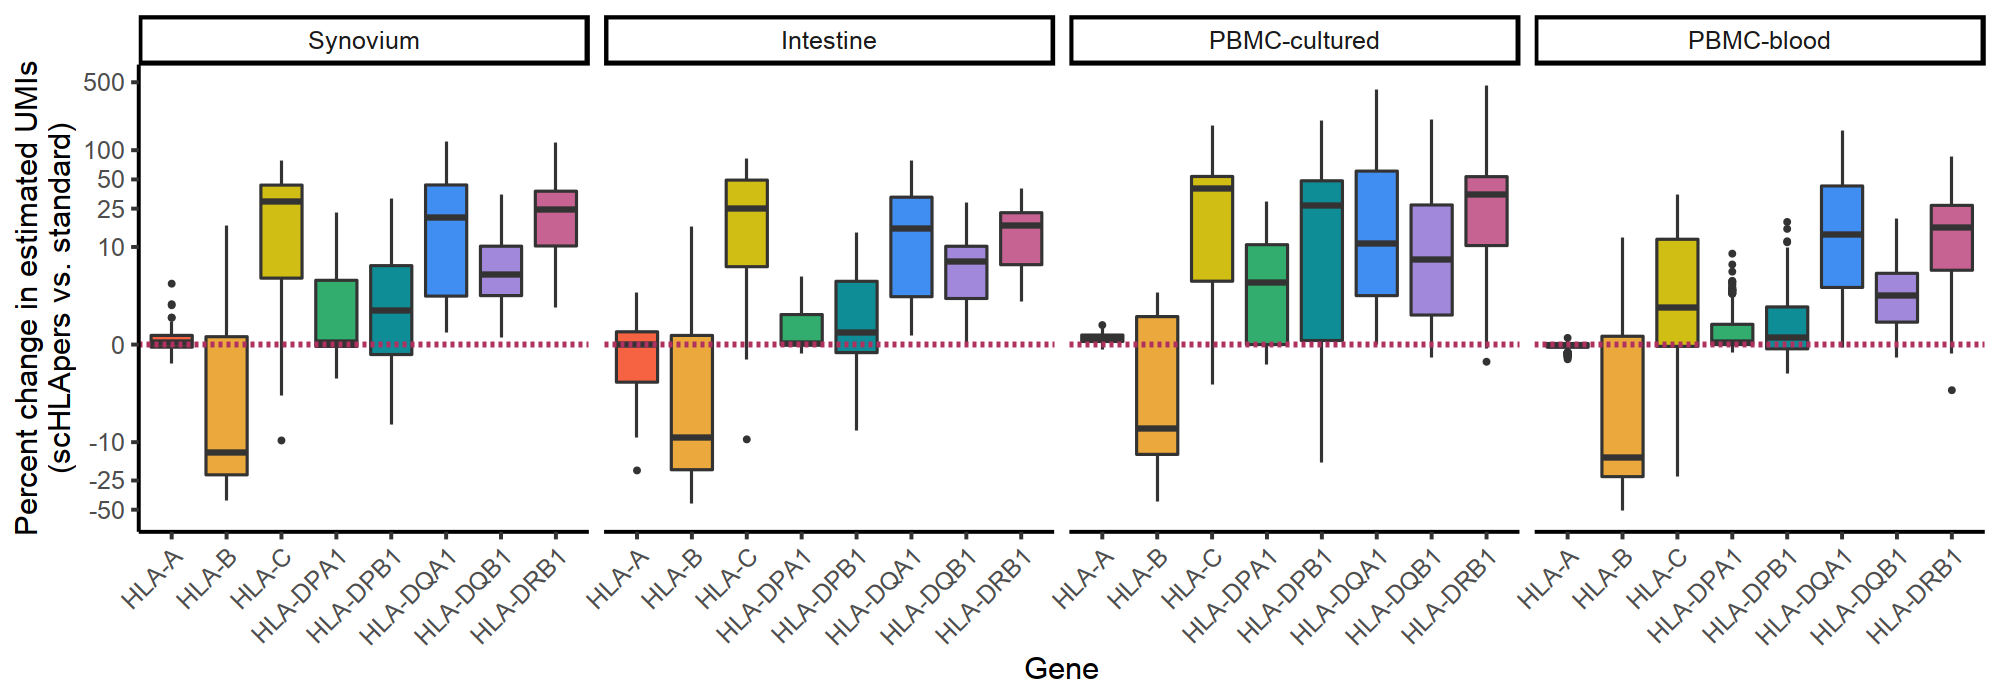

In [63]:
fig.size(3.5, 10)
pdf(file = '../../SuppFigs/Compare_percent_change_all_cohorts.pdf', width = 10, height = 3.5)
p = ggplot(pct_inc_combined) +
    geom_boxplot(aes(x = gene, y = pct_change, fill = gene), outlier.size = 0.4, lwd = 0.4) + theme_bw() +
    xlab('Gene') + ylab('Percent change in estimated UMIs\n(scHLApers vs. standard)') + 
    theme_classic() + theme(legend.position = 'none') +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + 
    scale_fill_manual(values = gene_colors) +
    geom_hline(yintercept=0, color = 'maroon', size = 0.75, linetype = 'dashed') + facet_wrap(~dataset, ncol=5) +
    scale_y_continuous(trans = pseudolog10_trans, 
                       breaks = c(-100, -50, -25, -10, 0, 10, 25, 50, 100, 500))
print(p)
dev.off()
p

Outliers are defined on the log-scale

## Write supp table

In [64]:
s_table = pct_inc_combined %>% 
    group_by(gene, dataset) %>% dplyr::summarise(mean = round(mean(pct_change), 3),
                                        median = round(median(pct_change), 3),
                                        q25 = round(quantile(pct_change, probs = c(.25)), 3),
                                        q75 = round(quantile(pct_change, probs = c(.75)), 3))
write.csv(s_table, '../../SuppTables/Table_pct_inc_stats.csv', quote = F, row.names = F)

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.


In [65]:
saveRDS(pct_inc_combined, 'percent_change_results/pct_inc_combined.rds')

# Percent Change vs. Distance (3' end)
Here we assess how expression is changing from noPers to Pers with respect to distance between the noPers and Pers sequence.
For each classical gene we compute: <br> <br>
percent change = (pers_exp - noPers_exp) / noPers_exp <br>
distance = lev(GRCh38_allele, imputed_allele) <br> <br>
There should be a positive correlation between percent change vs. distance if personalization saves more reads than it loses. Note: personalization may still be working even if there is negative correlation. Ex: read jumping.

In [1]:
suppressPackageStartupMessages({
    library(dplyr)
    library(ggplot2)
    library(stringr)
    library(stats)
    library(tidyverse)
    library(Matrix)
    library(ggrepel)
    library(SeuratObject)
    library(ggpubr)
    library(rstatix)
    library(uwot)
    library(singlecellmethods)
    library(irlba)
    library(stringdist)
    library(MASS)
    library(Rsamtools)
})

source('../utils.R')

**Percent Change vs. Distance Functions**

In [2]:
# Formats the name of an HLA allele from HLA_X*ii:jj:kk to X-ii-jj
format_allele = function(allele) {
    gene = str_split(str_split(allele, '_')[[1]][2], '\\*')[[1]][1]
    two_digit = str_split(str_split(allele, '\\*')[[1]][2], ':')[[1]][1]
    four_digit = str_split(str_split(allele, '\\*')[[1]][2], ':')[[1]][2]
    return(paste(gene, two_digit, four_digit, sep='-'))
}

# database and call names do not match, so look up is not trivial
# get sequence from database given allele name from call 
get_sequence = function(allele) {
    to_match = format_allele(allele) # HLA_X*ii:jj:kk to X-ii-jj
    idxs = which(formatted_database_names==to_match) # get indices of matching sequences
    if (length(idxs) == 0) {
        print(paste0('WARNING: ', to_match, ' not found'))
        return('null string')
    } else {
        return(as.character(database[idxs[1]]))
    }
}

# gene is in the format: 'A', 'B','C',...
get_dist = function(sample, gene, allele_dir, smillie=FALSE) {
    
    grch38_alleles = c('HLA_A*03:01:01', 'HLA_B*07:02:01', 'HLA_C*07:02:01', 'HLA_DRB1*15:01:01',
                      'HLA_DQA1*01:02:01', 'HLA_DQB1*06:02:01', 'HLA_DPA1*01:03:01', 'HLA_DPB1*04:01:01')
    names(grch38_alleles) = c('A', 'B', 'C', 'DRB1', 'DQA1', 'DQB1', 'DPA1', 'DPB1')
    
    if (smillie) {
        ind = str_split(sample, '\\.')[[1]][1]
        calls = read.csv(paste0(allele_dir, '/', ind, '_alleles.csv'))$ID # get allele calls for sample
    } else {
        calls = read.csv(paste0(allele_dir, '/', sample, '_alleles.csv'))$ID # get allele calls for sample
    }
    alleles = calls[which(grepl(paste0('HLA_', gene), calls, fixed=TRUE))]
    
    if (length(alleles)==1) { # if homozygous same allele is used for allele 1 and 2
        ref_seq = get_sequence(grch38_alleles[gene])
        seq1 = get_sequence(alleles[1])
        dist1 = stringdist(seq1, ref_seq, method='lv')
        results = c(alleles[1], alleles[1], dist1, dist1)
        names(results) = c('pers_allele1', 'pers_allele2', 'str_dist1', 'str_dist2')
        if (seq1=='null string') {print(sample)}
        return(results)
    } else {
        ref_seq = get_sequence(grch38_alleles[gene])
        seq1 = get_sequence(alleles[1])
        dist1 = stringdist(seq1, ref_seq, method='lv')
        seq2 = get_sequence(alleles[2])
        dist2 = stringdist(seq2, ref_seq, method='lv')
        results = c(alleles[1], alleles[2], dist1, dist2)
        names(results) = c('pers_allele1', 'pers_allele2', 'str_dist1', 'str_dist2')   
        if (seq1=='null string' | seq2=='null string') {print(sample)}
        return(results)
    }
}

get_dist_percentChange = function(pers, noPers, cohort_name, smillie=FALSE, amp2sle=FALSE, onek1k = FALSE, classIOnly = FALSE) {
    
    col_names = c('cohort', 'sample', 'gene', 'pers_allele1', 'pers_allele2', 'dist1', 'dist2', 'meanDist',
                  'noPers_summed_exp', 'pers_summed_exp', 'percentChange')
    df = data.frame(matrix(nrow=0, ncol=length(col_names), dimnames=list(NULL, col_names)))
    
    if (amp2sle) {
        get_sample = function(x) {return(paste(str_split(x, '_')[[1]][1], str_split(x, '_')[[1]][2], str_split(x, '_')[[1]][3], sep = '_'))}
    } else if (onek1k) {
        get_sample = function(x) {return(paste(str_split(x, '_')[[1]][1], str_split(x, '_')[[1]][2], sep = '_'))}
    } else {
        get_sample = function(x) {return(str_split(x, '_')[[1]][1])}
    }
    samples = unlist(unique(lapply(colnames(pers), get_sample)))
    
    if (classIOnly) {
        classical = c('A', 'B', 'C')
    } else {
        classical = c('A', 'B', 'C', 'DRB1', 'DQA1', 'DQB1', 'DPA1', 'DPB1')
    }
    
    for (sample in samples) {    
        sample_cells = colnames(pers)[which(grepl(sample, colnames(pers), fixed=TRUE))]
        pers_summed = rowSums(pers[,sample_cells])
        noPers_summed = rowSums(noPers[,sample_cells])
        for (gene in classical) {
            r = get_dist(sample, gene, allele_dir, smillie)
            meanDist = mean(c(as.numeric(r['str_dist1']), as.numeric(r['str_dist2'])))
            percentChange = 100*(pers_summed[paste0('IMGT_', gene)] - noPers_summed[paste0('IMGT_', gene)])/noPers_summed[paste0('IMGT_', gene)]
            df[nrow(df)+1,] = c(cohort_name, sample, gene, r['pers_allele1'], r['pers_allele2'],
                                r['str_dist1'], r['str_dist2'], meanDist, noPers_summed[paste0('IMGT_', gene)],
                                pers_summed[paste0('IMGT_', gene)], percentChange)
        }
    }
    
    numeric_cols = c('dist1', 'dist2', 'meanDist', 'noPers_summed_exp', 'pers_summed_exp', 'percentChange')
    df[numeric_cols] = sapply(df[numeric_cols], as.numeric)
    return(df)
}

**Run Percent Change vs. Distance:**
Inputs:
1. out: path to save results
2. sequence_database_path: 3 prime classical allele sequence database
3. allele_dir (for each cohort): imputed allele directory with files in the format [sample]_alleles.csv
4. sample_meta, cell_meta, genesXcells_pers, genesXcells_noPers (for each cohort)

`cat *.fasta > classical_3p_pileup.fasta`

In [3]:
# Global variables
sequence_database_path = '../../data/MSA_3p_end_fastas/classical_3p_pileup.fasta'
database = Biostrings::readDNAStringSet(sequence_database_path)
formatted_database_names = lapply(names(database), format_allele)
out = './percent_change_results'

## AMP2RA

In [4]:
allele_dir = '../../data/hla_alleles/RA_updated_alleles/'
sample_meta = read.csv('../../data/meta/sample_meta_AMP2RA_completeHLA.csv', row.names = 1)
cell_meta = read.csv('../../data/meta/cell_meta_AMP2RA_completeHLA.csv', row.names = 1)
genesXcells_pers = readRDS('../../data/genesXcells_GeneFull_Ex50pAS/exp_AMP2RA_pers_EM_GeneFull_Exon50pAS.rds')
genesXcells_noPers = readRDS('../../data/genesXcells_GeneFull_Ex50pAS/exp_AMP2RA_noPers_noMM_GeneFull_Exon50pAS.rds')
cell_meta = cell_meta %>% filter(Sample %in% sample_meta$Sample) # Subset cell_meta to the samples included in sample metadata
pers_hla = rownames(genesXcells_pers)[which(grepl('IMGT_', rownames(genesXcells_pers), fixed = TRUE))]
noPers_hla = c('HLA-A', 'HLA-C', 'HLA-B', 'HLA-DRB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1')
pers = genesXcells_pers[pers_hla, cell_meta$Cell] # match dimensions
noPers = genesXcells_noPers[noPers_hla, cell_meta$Cell] # match dimensions
rownames(noPers) = c('IMGT_A', 'IMGT_C', 'IMGT_B', 'IMGT_DRB1', 'IMGT_DQA1', 'IMGT_DQB1', 'IMGT_DPA1', 'IMGT_DPB1')
df = get_dist_percentChange(pers, noPers, 'AMP2RA')
write.csv(df, paste0(out, '/AMP2RA_percentChange_pileup.csv'), row.names=FALSE)

## Randolph2021

In [5]:
allele_dir = '../../data/hla_alleles/Randolph_alleles/'
sample_meta = read.csv('../../data/meta/sample_meta_Randolph_completeHLA.csv', row.names = 1)
cell_meta = read.csv('../../data/meta/cell_meta_Randolph_completeHLA.csv', row.names = 1)
genesXcells_pers = readRDS('../../data/genesXcells_GeneFull_Ex50pAS/exp_Randolph2021_pers_EM_GeneFull_Exon50pAS.rds')
genesXcells_noPers = readRDS('../../data/genesXcells_GeneFull_Ex50pAS/exp_Randolph2021_noPers_noMM_GeneFull_Exon50pAS.rds')
cell_meta = cell_meta %>% filter(Sample %in% sample_meta$Sample)
pers_hla = rownames(genesXcells_pers)[which(grepl('IMGT_', rownames(genesXcells_pers), fixed = TRUE))]
noPers_hla = c('HLA-A', 'HLA-C', 'HLA-B', 'HLA-DRB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1')
pers = genesXcells_pers[pers_hla, cell_meta$Cell] # Subset and match the ordering of cells in genesXcells to cell_meta
noPers = genesXcells_noPers[noPers_hla, cell_meta$Cell] # Subset and match the ordering of cells in genesXcells to cell_meta
rownames(noPers) = c('IMGT_A', 'IMGT_C', 'IMGT_B', 'IMGT_DRB1', 'IMGT_DQA1', 'IMGT_DQB1', 'IMGT_DPA1', 'IMGT_DPB1')
df = get_dist_percentChange(pers, noPers, 'Randolph2021')
write.csv(df, paste0(out, '/Randolph2021_percentChange_pileup.csv'), row.names=FALSE)

[1] "WARNING: DRB1-01-33N not found"
[1] "HMN83553"
[1] "WARNING: A-03-36N not found"
[1] "HMN83569"


## Smillie2019

In terminal:

`cd /data/srlab1/jkang/hla2023/data/hla_alleles`

`cp ./ccdg_broad/*.csv ./Smillie_alleles`

`cp ./Helmsley_merged/*.csv Smillie_alleles`

In [7]:
allele_dir = '/data/srlab1/jkang/hla2023/data/hla_alleles/Smillie_alleles'
sample_meta = read.csv('../../data/meta/sample_meta_Smillie_completeHLA.csv', row.names = 1)
cell_meta = read.csv('../../data/meta/cell_meta_Smillie_completeHLA.csv', row.names = 1)
genesXcells_pers = readRDS('../../data/genesXcells_GeneFull_Ex50pAS/exp_Smillie_pers_EM_GeneFull_Exon50pAS.rds')
genesXcells_noPers = readRDS('../../data/genesXcells_GeneFull_Ex50pAS/exp_Smillie_noPers_noMM_GeneFull_Exon50pAS.rds')
fix_sample = function(x) {
    vals = str_split(x, '\\.')[[1]]
    return(paste0(vals[1], '_', vals[2], '_', vals[3]))
}
cell_meta$Cell = unlist(lapply(cell_meta$Cell, fix_sample))
colnames(genesXcells_pers) = unlist(lapply(colnames(genesXcells_pers), fix_sample))
colnames(genesXcells_noPers) = unlist(lapply(colnames(genesXcells_noPers), fix_sample))
cell_meta = cell_meta %>% filter(Sample %in% sample_meta$Sample)
pers_hla = rownames(genesXcells_pers)[which(grepl('IMGT_', rownames(genesXcells_pers), fixed = TRUE))]
noPers_hla = c('HLA-A', 'HLA-C', 'HLA-B', 'HLA-DRB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1') # Joyce switched C and B
pers = genesXcells_pers[pers_hla, cell_meta$Cell] # Subset and match the ordering of cells in genesXcells to cell_meta
noPers = genesXcells_noPers[noPers_hla, cell_meta$Cell] # Subset and match the ordering of cells in genesXcells to cell_meta
rownames(noPers) = c('IMGT_A', 'IMGT_C', 'IMGT_B', 'IMGT_DRB1', 'IMGT_DQA1', 'IMGT_DQB1', 'IMGT_DPA1', 'IMGT_DPB1') # Joyce switched C and B
df = get_dist_percentChange(pers, noPers, 'Smillie2019', smillie=TRUE)
write.csv(df, paste0(out, '/Smillie2019_percentChange_pileup.csv'), row.names=FALSE)

[1] "WARNING: B-15-18 not found"
[1] "N16"


## OneK1K

In [6]:
allele_dir = '../../data/hla_alleles/1K1K_alleles/'
sample_meta = read.csv('../../data/meta/sample_meta_OneK1K_completeHLA.csv', row.names = 1)
cell_meta = read.csv('../../data/meta/cell_meta_OneK1K_completeHLA.csv', row.names = 1)
genesXcells_pers = readRDS('../../data/genesXcells_GeneFull_Ex50pAS/exp_OneK1K_pers_EM_GeneFull_Exon50pAS.rds')
genesXcells_noPers = readRDS('../../data/genesXcells_GeneFull_Ex50pAS/exp_OneK1K_noPers_noMM_GeneFull_Exon50pAS.rds')
cell_meta = cell_meta %>% filter(Sample %in% sample_meta$Sample)
pers_hla = rownames(genesXcells_pers)[which(grepl('IMGT_', rownames(genesXcells_pers), fixed = TRUE))]
noPers_hla = c('HLA-A', 'HLA-C', 'HLA-B', 'HLA-DRB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1')
pers = genesXcells_pers[pers_hla, cell_meta$Cell] # Subset and match the ordering of cells in genesXcells to cell_meta
noPers = genesXcells_noPers[noPers_hla, cell_meta$Cell] # Subset and match the ordering of cells in genesXcells to cell_meta
rownames(noPers) = c('IMGT_A', 'IMGT_C', 'IMGT_B', 'IMGT_DRB1', 'IMGT_DQA1', 'IMGT_DQB1', 'IMGT_DPA1', 'IMGT_DPB1')
df = get_dist_percentChange(pers, noPers, 'OneK1K', onek1k = T)
write.csv(df, paste0(out, '/OneK1K_percentChange_pileup.csv'), row.names=FALSE)

[1] "WARNING: DRB1-07-10N not found"
[1] "920_921"
[1] "WARNING: DRB1-07-10N not found"
[1] "454_455"
[1] "WARNING: DRB1-07-10N not found"
[1] "532_533"
[1] "WARNING: A-03-36N not found"
[1] "184_185"
[1] "WARNING: DRB1-07-10N not found"
[1] "203_204"


## Concatenate cohorts

In [6]:
# concatenate results
amp2ra = read.csv(paste0(out, '/AMP2RA_percentChange_pileup.csv'))
smillie = read.csv(paste0(out, '/Smillie2019_percentChange_pileup.csv'))
randolph2021 = read.csv(paste0(out, '/Randolph2021_percentChange_pileup.csv'))
onek1k = read.csv(paste0(out, '/OneK1K_percentChange_pileup.csv'))
df = rbind(amp2ra, randolph2021)
df = rbind(df, smillie)
df = rbind(df, onek1k)
write.csv(df, paste0(out, '/Four_cohorts_percentChange_pileup.csv'), row.names=FALSE)

The following samples were (incorrectly) assigned a distance of 500 for an allele due to it being a nonproductive allele (N). We do not supply a personalized chromosome for such alleles so we will assign the meanDist to the dist of the second allele in these cases.

In [7]:
which(df$gene == 'DRB1' & df$meanDist > 200 & df$percentChange < 50)
df[which(df$gene == 'DRB1' & df$meanDist > 200 & df$percentChange < 50),]
df[which(df$gene == 'B' & df$meanDist > 200 & df$percentChange < 50),]
df[580, 'meanDist'] = df[580, 'dist2']
df[3124, 'meanDist'] = df[3124, 'dist2']
df[3604, 'meanDist'] = df[3604, 'dist1']
df[4764, 'meanDist'] = df[4764, 'dist2']
df[8268, 'meanDist'] = df[8268, 'dist1']
df[1194, 'meanDist'] = df[1194, 'dist1']

[1]  580 3124 3604 4764 8268

,cohort,sample,gene,pers_allele1,pers_allele2,dist1,dist2,meanDist,noPers_summed_exp,pers_summed_exp,percentChange
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
580,Randolph2021,HMN83553,DRB1,HLA_DRB1*01:33N,HLA_DRB1*12:01,500,26,263.0,862,890.9889,3.36298144
3124,OneK1K,920_921,DRB1,HLA_DRB1*07:10N,HLA_DRB1*11:04,500,29,264.5,2628,2793.5239,6.29847489
3604,OneK1K,454_455,DRB1,HLA_DRB1*04:01,HLA_DRB1*07:10N,59,500,279.5,669,924.7433,38.22769806
4764,OneK1K,532_533,DRB1,HLA_DRB1*07:10N,HLA_DRB1*16:01,500,2,251.0,429,429.2754,0.06420746
8268,OneK1K,203_204,DRB1,HLA_DRB1*07:01,HLA_DRB1*07:10N,61,500,280.5,660,904.0000,36.96969697


,cohort,sample,gene,pers_allele1,pers_allele2,dist1,dist2,meanDist,noPers_summed_exp,pers_summed_exp,percentChange
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
1194,Smillie2019,N16,B,HLA_B*08:01,HLA_B*15:18,1,500,250.5,25548,25477.48,-0.2760369


In [8]:
which(df$gene == 'A' & df$meanDist > 200 & df$percentChange < 10)
df[which(df$gene == 'A' & df$meanDist > 200 & df$percentChange < 10),]
df[673, 'meanDist'] = df[673, 'dist1']
df[7233, 'meanDist'] = df[7233, 'dist1']

[1]  673 7233

,cohort,sample,gene,pers_allele1,pers_allele2,dist1,dist2,meanDist,noPers_summed_exp,pers_summed_exp,percentChange
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
673,Randolph2021,HMN83569,A,HLA_A*02:05,HLA_A*03:36N,4,500,252,9030,9024,-0.06644518
7233,OneK1K,184_185,A,HLA_A*02:01,HLA_A*03:36N,4,500,252,3144,3145,0.03180662


In [9]:
write.csv(df, paste0(out, '/Four_cohorts_percentChange_pileup_corrected.csv'), row.names=FALSE)

The following `from` values were not present in `x`: Smillie, Randolph_NI, Randolph

Warning message:
“Ignoring unknown parameters: linewidth”
`geom_smooth()` using formula 'y ~ x'



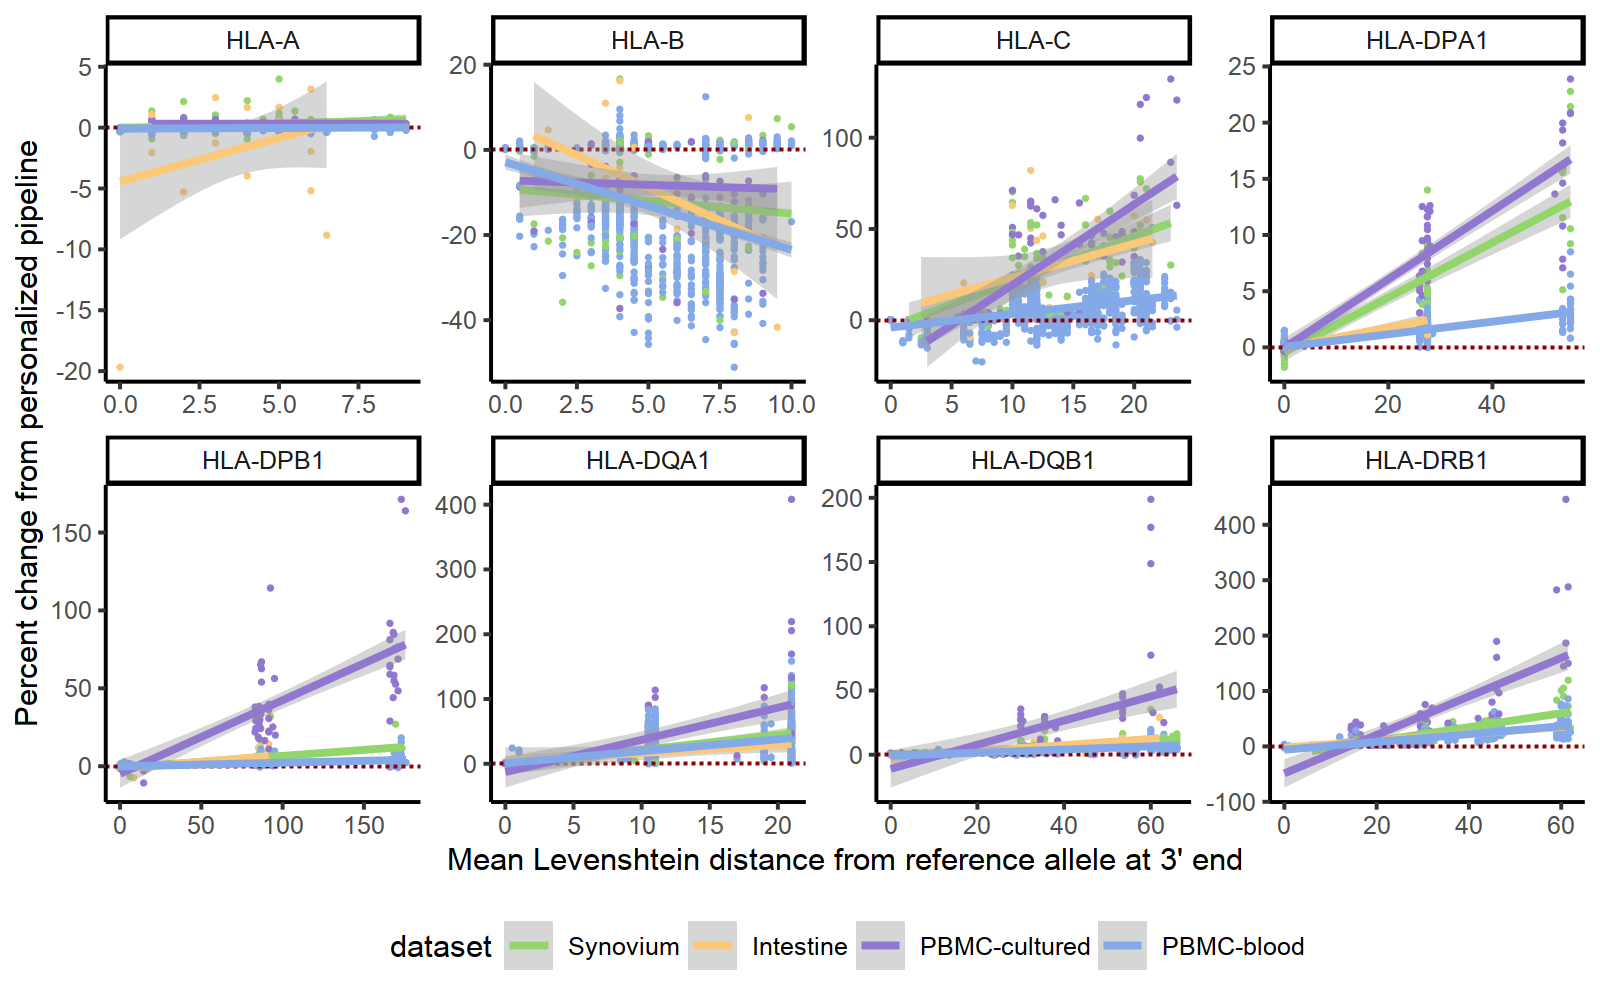

In [10]:
df$cohort = plyr::revalue(df$cohort, old_new_dataset_names)
df$cohort_factor = factor(df$cohort, levels = c('Synovium', 'Intestine', 'PBMC-cultured', 'PBMC-blood'))

## Add trendlines
fig.size(5, 8)
p = ggplot(sample_frac(df, 1L)) +
    geom_point(aes(x = meanDist, y = percentChange, col = cohort_factor), size = 0.3) +
    theme_classic() + 
    geom_hline(yintercept=0, linetype="dashed", color = "darkred") +
    facet_wrap(~ paste0('HLA-', gene), scales = 'free', ncol = 4) + 
    scale_color_manual(values = cohort_colors) + theme(legend.position = 'bottom') +
    ylab('Percent change from personalized pipeline') + xlab('Mean Levenshtein distance from reference allele at 3\' end') +
    geom_smooth(aes(x = meanDist, y = percentChange, col = cohort_factor), method=lm, linewidth = 1) + labs(col = 'dataset')
p

Warning message:
“Ignoring unknown parameters: linewidth”
`geom_smooth()` using formula 'y ~ x'



png 
  2

`geom_smooth()` using formula 'y ~ x'



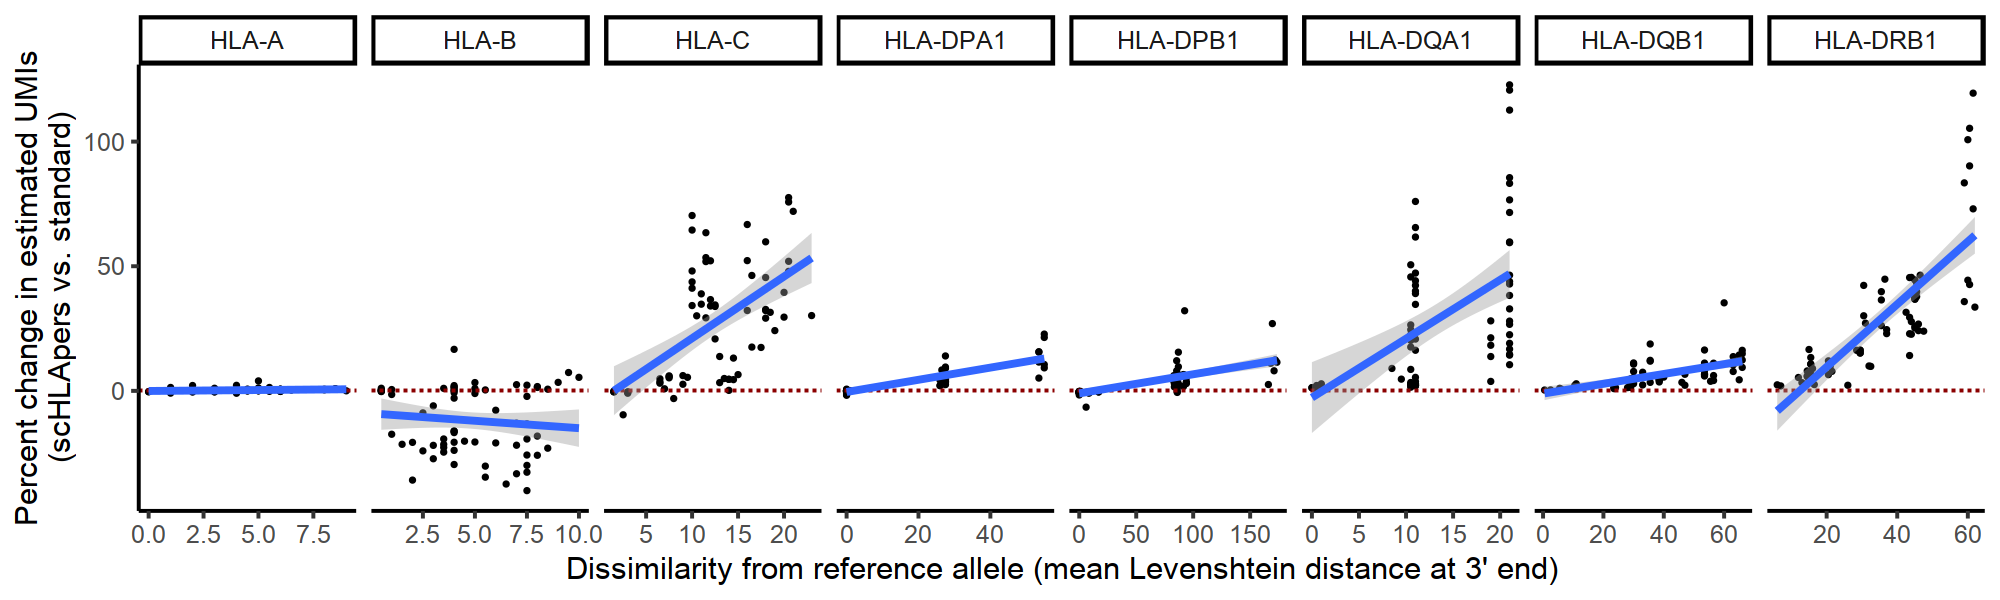

In [11]:
fig.size(3, 10)
## Add trendlines
pdf(file = '../../SuppFigs/Perc_change_v_Lev_dist_freey_trendOne_AMP2RA.pdf', width = 10, height = 3)
p = ggplot(sample_frac(df %>% filter(cohort %in% c('Synovium')), 1L)) +
    geom_point(aes(x = meanDist, y = percentChange), size = 0.3) +
    theme_classic() + 
    geom_hline(yintercept=0, linetype="dashed", color = "darkred") +
    facet_wrap(~ paste0('HLA-', gene), scales = 'free_x', ncol = 8) + 
    scale_color_manual(values = cohort_colors) + theme(legend.position = 'bottom') +
    xlab('Dissimilarity from reference allele (mean Levenshtein distance at 3\' end)') +
    ylab('Percent change in estimated UMIs\n(scHLApers vs. standard)') +
    geom_smooth(aes(x = meanDist, y = percentChange), method=lm, linewidth = 1)
    
print(p)
dev.off()
p

# Percent Change vs. Distance (5' end)

To run this section, first run the notebook `4_Randolph_long_short_AMP_5p.ipynb` to generate the 5-prime results.

`cat *.fasta > classical_5p_pileup.fasta`

In [4]:
# Global variables
sequence_database_path = '../../data/MSA_5p_end_fastas/classical_5p_pileup.fasta'
database = Biostrings::readDNAStringSet(sequence_database_path)
formatted_database_names = lapply(names(database), format_allele)
out = './percent_change_results'

## AMP2RA

In [5]:
allele_dir = '../../data/hla_alleles/RA_updated_alleles/'
sample_meta = read.csv('../../data/meta/sample_meta_AMP2RA_completeHLA.csv', row.names = 1)
cell_meta = read.csv('../../data/meta/AMP5prime_metadata_Syn.csv', row.names = 1)
sample_meta = sample_meta %>% filter(Sample %in% cell_meta$Sample)
genesXcells_pers = readRDS('../../data/genesXcells_GeneFull_Ex50pAS/exp_AMP2RA_5prime_pers_EM_GeneFull_Exon50pAS.rds')
genesXcells_noPers = readRDS('../../data/genesXcells_GeneFull_Ex50pAS/exp_AMP2RA_5prime_noPers_noMM_GeneFull_Exon50pAS.rds')
cell_meta = cell_meta %>% filter(Sample %in% sample_meta$Sample) # Subset cell_meta to the samples included in sample metadata
pers_hla = c('HLA-A', 'HLA-C', 'HLA-B', 'HLA-DRB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1')
noPers_hla = c('HLA-A', 'HLA-C', 'HLA-B', 'HLA-DRB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1')
pers = genesXcells_pers[pers_hla, cell_meta$Cell] # match dimensions
noPers = genesXcells_noPers[noPers_hla, cell_meta$Cell] # match dimensions
rownames(noPers) = c('IMGT_A', 'IMGT_C', 'IMGT_B', 'IMGT_DRB1', 'IMGT_DQA1', 'IMGT_DQB1', 'IMGT_DPA1', 'IMGT_DPB1')
rownames(pers) = c('IMGT_A', 'IMGT_C', 'IMGT_B', 'IMGT_DRB1', 'IMGT_DQA1', 'IMGT_DQB1', 'IMGT_DPA1', 'IMGT_DPB1')
df = get_dist_percentChange(pers, noPers, 'AMP2RA', classIOnly = TRUE)
write.csv(df, paste0(out, '/AMP2RA_percentChange_pileup_5p.csv'), row.names=FALSE)

# Compare the range of dissimilarity from ref for 5' and 3' (AMP2RA)

In [6]:
df_3p = read.csv('./percent_change_results/AMP2RA_percentChange_pileup.csv') %>% filter(gene %in% c('A', 'B', 'C'))
df_5p = read.csv('./percent_change_results/AMP2RA_percentChange_pileup_5p.csv')
df_3p %>% group_by(gene) %>% summarise(mean = mean(meanDist))
df_5p %>% group_by(gene) %>% summarise(mean = mean(meanDist))

df_1 = df_3p[, c('gene', 'pers_allele1', 'dist1')]
df_2 = df_3p[, c('gene', 'pers_allele2', 'dist2')]
colnames(df_2) = c('gene', 'pers_allele1', 'dist1')
df_long_3p = rbind(df_1, df_2)

df_1 = df_5p[, c('gene', 'pers_allele1', 'dist1')]
df_2 = df_5p[, c('gene', 'pers_allele2', 'dist2')]
colnames(df_2) = c('gene', 'pers_allele1', 'dist1')
df_long_5p = rbind(df_1, df_2)

gene,mean
<chr>,<dbl>
A,4.108696
B,4.702899
C,12.072464


gene,mean
<chr>,<dbl>
A,16.33333
B,19.00000
C,11.83333


In [7]:
df_long_3p$chemistry = '3-prime'
df_long_5p$chemistry = '5-prime'
dfPlot = rbind(df_long_3p, df_long_5p)

png 
  2

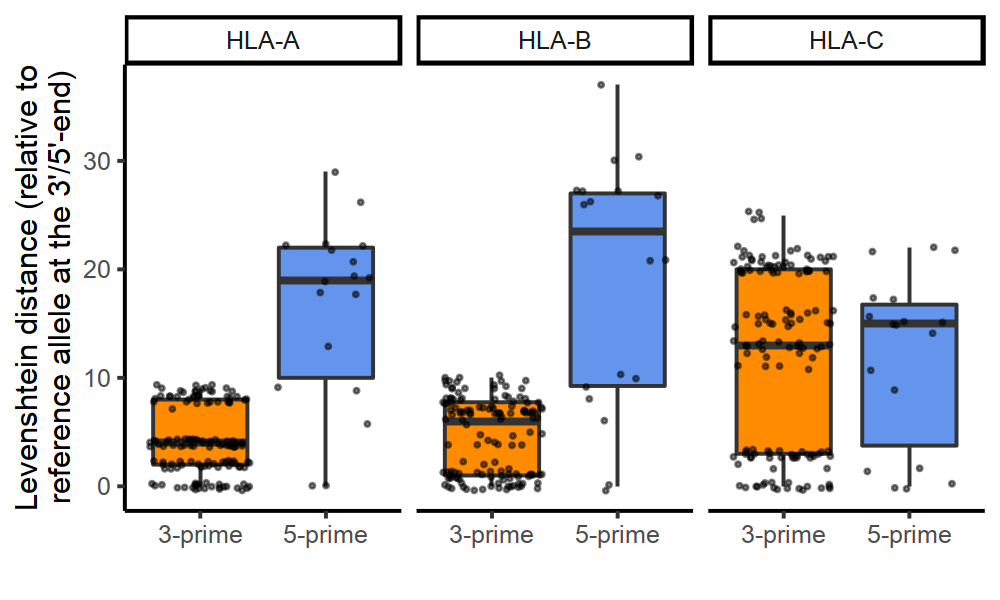

In [8]:
fig.size(3, 5)
pdf('../../SuppFigs/LevDist_ABC_5p3p_Synovium.pdf', width = 5, height = 3)
p = dfPlot %>% mutate(gene = paste0('HLA-', gene)) %>%
    ggplot(aes(x = chemistry, y = dist1, fill = chemistry)) + 
    geom_boxplot() + geom_jitter(color="black", size=0.4, alpha=0.5) + 
    theme_classic() + xlab('') + facet_wrap(~gene, scales = 'free_x') +
    theme(legend.position = 'none') + ylab("Levenshtein distance (relative to\nreference allele at the 3'/5'-end)") +
    scale_fill_manual(values = c('darkorange', 'cornflowerblue'))
print(p)
dev.off()
p

Warning message:
“Ignoring unknown parameters: linewidth”
`geom_smooth()` using formula 'y ~ x'



png 
  2

`geom_smooth()` using formula 'y ~ x'



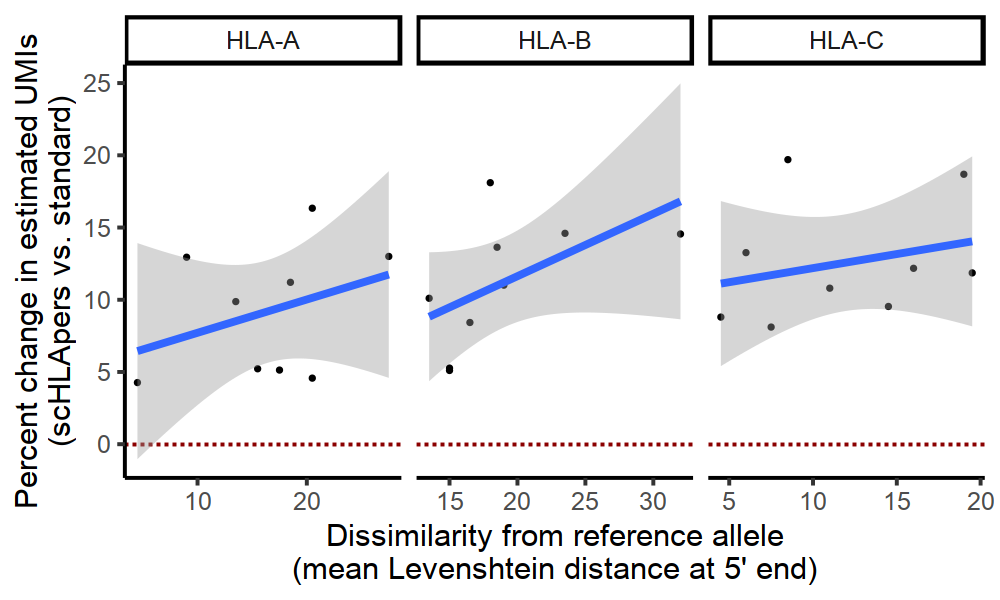

In [9]:
fig.size(3, 5)
pdf('../../SuppFigs/Perc_change_v_Lev_5p_Synovium.pdf', width = 5, height = 3)
p = df_5p %>% ggplot() + 
    geom_point(aes(x = meanDist, y = percentChange), size = 0.3) +
    theme_classic() + 
    geom_hline(yintercept=0, linetype="dashed", color = "darkred") +
    facet_wrap(~ paste0('HLA-', gene), scales = 'free_x', ncol = 8) + 
    scale_color_manual(values = cohort_colors) + theme(legend.position = 'bottom') +
    xlab('Dissimilarity from reference allele\n(mean Levenshtein distance at 5\' end)') +
    ylab('Percent change in estimated UMIs\n(scHLApers vs. standard)') +
    geom_smooth(aes(x = meanDist, y = percentChange), method=lm, linewidth = 1)
print(p)
dev.off()
p

# Are there certain combinations of HLA-B / C alleles that tend to have more switching between B and C alleles?

In [11]:
out = './percent_change_results'
df = read.csv(paste0(out, '/Four_cohorts_percentChange_pileup.csv'))

Find HLA-B and HLA-C alleles that tend to go down/up together.

In [12]:
for (s in unique(df$sample)) {
    pchange_B = df[which(df$sample == s & df$gene == 'B'), 'percentChange']
    pchange_C = df[which(df$sample == s & df$gene == 'C'), 'percentChange']
    
    if (pchange_B < -40 & pchange_C > 30) {
        print(df[which(df$sample == s & df$gene == 'B'), 'pers_allele1'])
        print(df[which(df$sample == s & df$gene == 'B'), 'pers_allele2'])
        
        print(df[which(df$sample == s & df$gene == 'C'), 'pers_allele1'])
        print(df[which(df$sample == s & df$gene == 'C'), 'pers_allele2'])
    }
}

[1] "HLA_B*13:02"
[1] "HLA_B*15:01"
[1] "HLA_C*03:03"
[1] "HLA_C*06:02"
[1] "HLA_B*52:01"
[1] "HLA_B*52:01"
[1] "HLA_C*12:02"
[1] "HLA_C*12:02"
[1] "HLA_B*45:01"
[1] "HLA_B*57:01"
[1] "HLA_C*06:02"
[1] "HLA_C*06:02"
[1] "HLA_B*37:01"
[1] "HLA_B*38:01"
[1] "HLA_C*06:02"
[1] "HLA_C*12:03"
[1] "HLA_B*38:01"
[1] "HLA_B*57:01"
[1] "HLA_C*06:02"
[1] "HLA_C*12:03"


In [13]:
for (s in unique(df$sample)) {
    pchange_B = df[which(df$sample == s & df$gene == 'B'), 'percentChange']
    pchange_C = df[which(df$sample == s & df$gene == 'C'), 'percentChange']
    
    if (pchange_B > 0 & pchange_C > 30) {
        print(df[which(df$sample == s & df$gene == 'B'), 'pers_allele1'])
        print(df[which(df$sample == s & df$gene == 'B'), 'pers_allele2'])
        
        print(df[which(df$sample == s & df$gene == 'C'), 'pers_allele1'])
        print(df[which(df$sample == s & df$gene == 'C'), 'pers_allele2'])
    }
}

[1] "HLA_B*42:01"
[1] "HLA_B*44:02"
[1] "HLA_C*05:01"
[1] "HLA_C*17:01"
[1] "HLA_B*08:01"
[1] "HLA_B*45:01"
[1] "HLA_C*06:02"
[1] "HLA_C*07:01"
[1] "HLA_B*08:01"
[1] "HLA_B*44:02"
[1] "HLA_C*05:01"
[1] "HLA_C*07:01"


In [14]:
has_HLA_group1 = c() # group of alleles from tree built in Jalview

for (s in unique(df$sample)) {
    HLA_C1 = df[which(df$sample == s & df$gene == 'C'), 'pers_allele1']
    HLA_C2 = df[which(df$sample == s & df$gene == 'C'), 'pers_allele2']
    
    if (HLA_C1 == "HLA_C*06:02" | HLA_C2 == "HLA_C*06:02" |
        startsWith(HLA_C1, "HLA_C*12") | startsWith(HLA_C2, "HLA_C*12") |
        startsWith(HLA_C1, "HLA_C*05") | startsWith(HLA_C2, "HLA_C*05") |
        startsWith(HLA_C1, "HLA_C*08") | startsWith(HLA_C2, "HLA_C*08") |
        startsWith(HLA_C1, "HLA_C*16") | startsWith(HLA_C2, "HLA_C*16") |
        startsWith(HLA_C1, "HLA_C*02") | startsWith(HLA_C2, "HLA_C*02") |
        startsWith(HLA_C1, "HLA_C*15") | startsWith(HLA_C2, "HLA_C*15" ) 
        )  {
        has_HLA_group1 = c(has_HLA_group1, s)
    }
}
length(has_HLA_group1)

[1] 633

In [15]:
has_bothHLA_group1 = c() # group of alleles from tree built in Jalview

for (s in unique(df$sample)) {
    HLA_C1 = df[which(df$sample == s & df$gene == 'C'), 'pers_allele1']
    HLA_C2 = df[which(df$sample == s & df$gene == 'C'), 'pers_allele2']
    
    if ( (HLA_C1 == "HLA_C*06:02" | 
        startsWith(HLA_C1, "HLA_C*12") |
        startsWith(HLA_C1, "HLA_C*05") |
        startsWith(HLA_C1, "HLA_C*08") |
        startsWith(HLA_C1, "HLA_C*16") |
        startsWith(HLA_C1, "HLA_C*02") |
        startsWith(HLA_C1, "HLA_C*15")) &
          ( HLA_C2 == "HLA_C*06:02" |
        startsWith(HLA_C2, "HLA_C*12") |
        startsWith(HLA_C2, "HLA_C*05") |
        startsWith(HLA_C2, "HLA_C*08") |
        startsWith(HLA_C2, "HLA_C*16") |
        startsWith(HLA_C2, "HLA_C*02") |
        startsWith(HLA_C2, "HLA_C*15" ))) {
        has_bothHLA_group1 = c(has_bothHLA_group1, s)
    }
}
length(has_bothHLA_group1)

[1] 161

In [16]:
has_bothHLA_group2 = c() # group of alleles from tree

for (s in unique(df$sample)) {
    HLA_C1 = df[which(df$sample == s & df$gene == 'C'), 'pers_allele1']
    HLA_C2 = df[which(df$sample == s & df$gene == 'C'), 'pers_allele2']
    
    if ((startsWith(HLA_C1, "HLA_C*04") | startsWith(HLA_C1, "HLA_C*14") | startsWith(HLA_C1, "HLA_C*18") | startsWith(HLA_C1, "HLA_C*01")|
        startsWith(HLA_C1, "HLA_C*03") | startsWith(HLA_C1, "HLA_C*07") | startsWith(HLA_C1, "HLA_C*17")) &
        (startsWith(HLA_C2, "HLA_C*04") | startsWith(HLA_C2, "HLA_C*14") | startsWith(HLA_C1, "HLA_C*18") | startsWith(HLA_C1, "HLA_C*01")|
        startsWith(HLA_C2, "HLA_C*03") | startsWith(HLA_C2, "HLA_C*07") | startsWith(HLA_C2, "HLA_C*17"))) {
        has_bothHLA_group2 = c(has_bothHLA_group2, s)
    }
}
length(has_bothHLA_group2)

[1] 467

In [17]:
df$has_HLA_group1 = ifelse(df$sample %in% has_HLA_group1, TRUE, FALSE)
df$has_bothHLA_group2 = ifelse(df$sample %in% has_bothHLA_group2, TRUE, FALSE)

df$num_HLA_group1_alleles = 0
df$num_HLA_group1_alleles[which(df$sample %in% has_HLA_group1)] = 1
df$num_HLA_group1_alleles[which(df$sample %in% has_bothHLA_group1)] = 2 

png 
  2

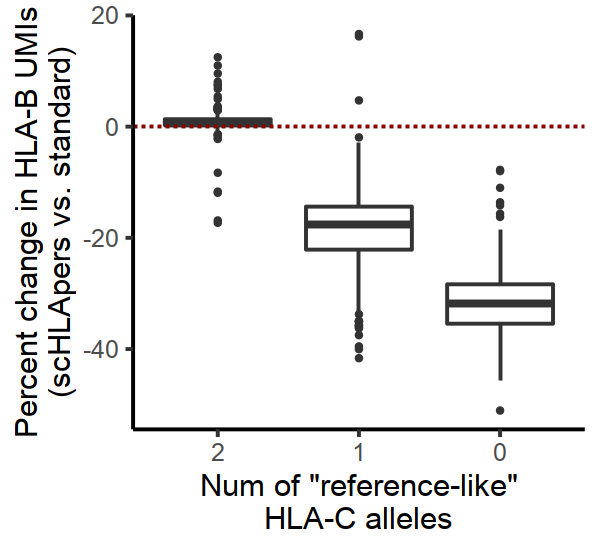

In [18]:
fig.size(2.75, 3)
## Add trendlines
pdf('../../SuppFigs/HLA-B_C_alleles_switching_dose_response.pdf', width = 3, height = 2.75)
p = ggplot(sample_frac(df %>% filter(gene == 'B'), 1L)) +
    geom_boxplot(aes(x = fct_rev(as.factor(2-num_HLA_group1_alleles)), 
                     y = percentChange), outlier.size = 0.5) +
    theme_classic() + 
    geom_hline(yintercept=0, linetype="dashed", color = "darkred") +
    ylab('Percent change in HLA-B UMIs\n(scHLApers vs. standard)') + 
    xlab('Num of "reference-like"\nHLA-C alleles')
print(p)
dev.off()
p

# All done!

In [19]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/hla_new/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] Rsamtools_2.6.0         Biostrings_2.58.0       XVector_0.30.0         
 [4] GenomicRanges_1.42.0    GenomeInfoDb_1.26.7     IRanges_2.24.1         
 [7] S4Vectors_0.28.1        BiocGenerics_0.36.1     MASS_7.3-55            
[10] string